# Image Captioning with LSTMs
In the previous exercise you implemented a vanilla RNN and applied it to image captioning. In this notebook you will implement the LSTM update rule and use it for image captioning.

In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


# Load MS-COCO data
As in the previous notebook, we will use the Microsoft COCO dataset for captioning.

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
  if type(v) == np.ndarray:
    print(k, type(v), v.shape, v.dtype)
  else:
    print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# LSTM
If you read recent papers, you'll see that many people use a variant on the vanialla RNN called Long-Short Term Memory (LSTM) RNNs. Vanilla RNNs can be tough to train on long sequences due to vanishing and exploding gradiants caused by repeated matrix multiplication. LSTMs solve this problem by replacing the simple update rule of the vanilla RNN with a gating mechanism as follows.

Similar to the vanilla RNN, at each timestep we receive an input $x_t\in\mathbb{R}^D$ and the previous hidden state $h_{t-1}\in\mathbb{R}^H$; the LSTM also maintains an $H$-dimensional *cell state*, so we also receive the previous cell state $c_{t-1}\in\mathbb{R}^H$. The learnable parameters of the LSTM are an *input-to-hidden* matrix $W_x\in\mathbb{R}^{4H\times D}$, a *hidden-to-hidden* matrix $W_h\in\mathbb{R}^{4H\times H}$ and a *bias vector* $b\in\mathbb{R}^{4H}$.

At each timestep we first compute an *activation vector* $a\in\mathbb{R}^{4H}$ as $a=W_xx_t + W_hh_{t-1}+b$. We then divide this into four vectors $a_i,a_f,a_o,a_g\in\mathbb{R}^H$ where $a_i$ consists of the first $H$ elements of $a$, $a_f$ is the next $H$ elements of $a$, etc. We then compute the *input gate* $g\in\mathbb{R}^H$, *forget gate* $f\in\mathbb{R}^H$, *output gate* $o\in\mathbb{R}^H$ and *block input* $g\in\mathbb{R}^H$ as

$$
\begin{align*}
i = \sigma(a_i) \hspace{2pc}
f = \sigma(a_f) \hspace{2pc}
o = \sigma(a_o) \hspace{2pc}
g = \tanh(a_g)
\end{align*}
$$

where $\sigma$ is the sigmoid function and $\tanh$ is the hyperbolic tangent, both applied elementwise.

Finally we compute the next cell state $c_t$ and next hidden state $h_t$ as

$$
c_{t} = f\odot c_{t-1} + i\odot g \hspace{4pc}
h_t = o\odot\tanh(c_t)
$$

where $\odot$ is the elementwise product of vectors.

In the rest of the notebook we will implement the LSTM update rule and apply it to the image captioning task.

# LSTM: step forward
Implement the forward pass for a single timestep of an LSTM in the `lstm_step_forward` function in the file `cs231n/rnn_layers.py`. This should be similar to the `rnn_step_forward` function that you implemented above, but using the LSTM update rule instead.

Once you are done, run the following to perform a simple test of your implementation. You should see errors around `1e-8` or less.

In [3]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('next_h error: ', rel_error(expected_next_h, next_h))
print('next_c error: ', rel_error(expected_next_c, next_c))

next_h error:  5.70541311858e-09
next_c error:  5.81431230888e-09


#LSTM: step backward
Implement the backward pass for a single LSTM timestep in the function `lstm_step_backward` in the file `cs231n/rnn_layers.py`. Once you are done, run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-8` or less.

In [4]:
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dh error: ', rel_error(dh_num, dh))
print('dc error: ', rel_error(dc_num, dc))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  5.65700474322e-09
dh error:  9.92974750514e-11
dc error:  1.50944686421e-10
dWx error:  1.30965093718e-08
dWh error:  2.11811828508e-08
db error:  1.30022610219e-10


# LSTM: forward
In the function `lstm_forward` in the file `cs231n/rnn_layers.py`, implement the `lstm_forward` function to run an LSTM forward on an entire timeseries of data.

When you are done run the following to check your implementation. You should see an error around `1e-7`.

In [5]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('h error: ', rel_error(expected_h, h))

h error:  8.61053745211e-08


# LSTM: backward
Implement the backward pass for an LSTM over an entire timeseries of data in the function `lstm_backward` in the file `cs231n/rnn_layers.py`. When you are done run the following to perform numeric gradient checking on your implementation. You should see errors around `1e-8` or less.

In [6]:
from cs231n.rnn_layers import lstm_forward, lstm_backward

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dx_num, dx))
print('dWx error: ', rel_error(dx_num, dx))
print('dWh error: ', rel_error(dx_num, dx))
print('db error: ', rel_error(dx_num, dx))

dx error:  2.13681339137e-09
dh0 error:  2.13681339137e-09
dWx error:  2.13681339137e-09
dWh error:  2.13681339137e-09
db error:  2.13681339137e-09


#LSTM captioning model
Now that you have implemented an LSTM, update the implementation of the `loss` method of the `CaptioningRNN` class in the file `cs231n/classifiers/rnn.py` to handle the case where `self.cell_type` is `lstm`. This should require adding less than 10 lines of code.

Once you have done so, run the following to check your implementation. You should see a difference of less than `1e-10`.

In [7]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.82445935443
expected loss:  9.82445935443
difference:  2.26130225656e-12


# Overfit LSTM captioning model
Run the following to overfit an LSTM captioning model on the same small dataset as we used for the RNN above.

(Iteration 1 / 100) loss: 74.517275
(Iteration 11 / 100) loss: 38.262037
(Iteration 21 / 100) loss: 24.226586
(Iteration 31 / 100) loss: 11.916632
(Iteration 41 / 100) loss: 7.949195
(Iteration 51 / 100) loss: 1.752342
(Iteration 61 / 100) loss: 1.526095
(Iteration 71 / 100) loss: 0.353667
(Iteration 81 / 100) loss: 0.172912
(Iteration 91 / 100) loss: 0.131952


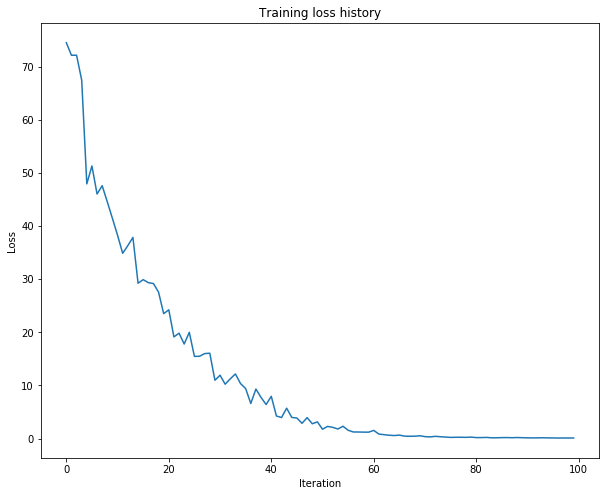

In [8]:
small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# LSTM test-time sampling
Modify the `sample` method of the `CaptioningRNN` class to handle the case where `self.cell_type` is `lstm`. This should take fewer than 10 lines of code.

When you are done run the following to sample from your overfit LSTM model on some training and validation set samples.

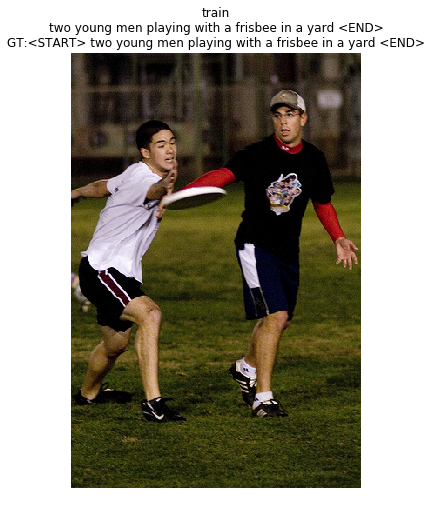

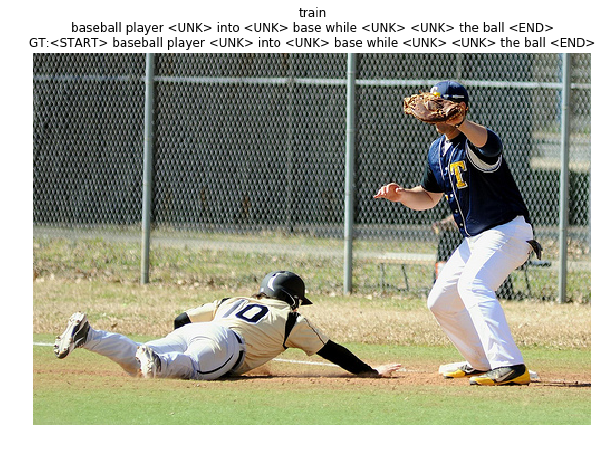

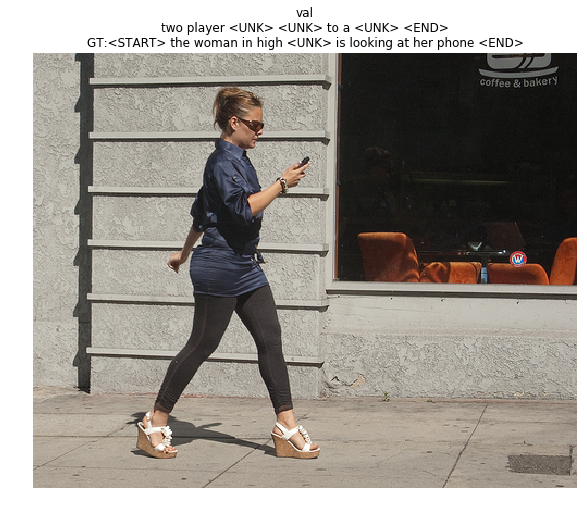

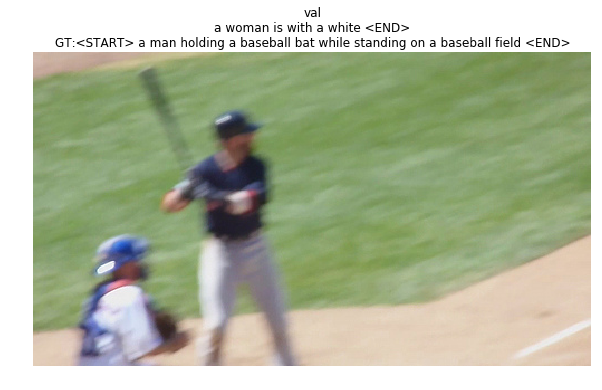

In [10]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = small_lstm_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()

# Train a good captioning model!
Using the pieces you have implemented in this and the previous notebook, try to train a captioning model that gives decent qualitative results (better than the random garbage you saw with the overfit models) when sampling on the validation set. You can subsample the training set if you want; we just want to see samples on the validatation set that are better than random.

Don't spend too much time on this part; we don't have any explicit accuracy thresholds you need to meet.

(Iteration 1 / 32000) loss: 73.051051
(Iteration 11 / 32000) loss: 55.690621
(Iteration 21 / 32000) loss: 53.471420
(Iteration 31 / 32000) loss: 43.662824
(Iteration 41 / 32000) loss: 42.341254
(Iteration 51 / 32000) loss: 43.161681
(Iteration 61 / 32000) loss: 42.650239
(Iteration 71 / 32000) loss: 40.212016
(Iteration 81 / 32000) loss: 42.257190
(Iteration 91 / 32000) loss: 40.535802
(Iteration 101 / 32000) loss: 38.009903
(Iteration 111 / 32000) loss: 34.251286
(Iteration 121 / 32000) loss: 42.099033
(Iteration 131 / 32000) loss: 42.176692
(Iteration 141 / 32000) loss: 39.881326
(Iteration 151 / 32000) loss: 36.172763
(Iteration 161 / 32000) loss: 36.607304
(Iteration 171 / 32000) loss: 35.629623
(Iteration 181 / 32000) loss: 36.120316
(Iteration 191 / 32000) loss: 34.373538
(Iteration 201 / 32000) loss: 38.727900
(Iteration 211 / 32000) loss: 35.065102
(Iteration 221 / 32000) loss: 33.885816
(Iteration 231 / 32000) loss: 33.638351
(Iteration 241 / 32000) loss: 38.675245
(Iteration 

(Iteration 2031 / 32000) loss: 28.874925
(Iteration 2041 / 32000) loss: 28.031573
(Iteration 2051 / 32000) loss: 25.714847
(Iteration 2061 / 32000) loss: 29.515657
(Iteration 2071 / 32000) loss: 28.423885
(Iteration 2081 / 32000) loss: 26.195250
(Iteration 2091 / 32000) loss: 26.909343
(Iteration 2101 / 32000) loss: 27.303241
(Iteration 2111 / 32000) loss: 26.262937
(Iteration 2121 / 32000) loss: 27.563318
(Iteration 2131 / 32000) loss: 29.904500
(Iteration 2141 / 32000) loss: 29.034117
(Iteration 2151 / 32000) loss: 27.248011
(Iteration 2161 / 32000) loss: 28.896335
(Iteration 2171 / 32000) loss: 29.245268
(Iteration 2181 / 32000) loss: 31.053124
(Iteration 2191 / 32000) loss: 29.602822
(Iteration 2201 / 32000) loss: 30.651928
(Iteration 2211 / 32000) loss: 25.949169
(Iteration 2221 / 32000) loss: 29.536651
(Iteration 2231 / 32000) loss: 30.082120
(Iteration 2241 / 32000) loss: 28.070601
(Iteration 2251 / 32000) loss: 28.189854
(Iteration 2261 / 32000) loss: 30.927809
(Iteration 2271 

(Iteration 4031 / 32000) loss: 28.219320
(Iteration 4041 / 32000) loss: 26.278766
(Iteration 4051 / 32000) loss: 29.852383
(Iteration 4061 / 32000) loss: 29.175049
(Iteration 4071 / 32000) loss: 29.988220
(Iteration 4081 / 32000) loss: 25.768273
(Iteration 4091 / 32000) loss: 25.578560
(Iteration 4101 / 32000) loss: 24.602351
(Iteration 4111 / 32000) loss: 27.313129
(Iteration 4121 / 32000) loss: 27.697409
(Iteration 4131 / 32000) loss: 27.056038
(Iteration 4141 / 32000) loss: 27.098953
(Iteration 4151 / 32000) loss: 23.518641
(Iteration 4161 / 32000) loss: 25.250388
(Iteration 4171 / 32000) loss: 24.605719
(Iteration 4181 / 32000) loss: 27.438985
(Iteration 4191 / 32000) loss: 25.461216
(Iteration 4201 / 32000) loss: 28.806423
(Iteration 4211 / 32000) loss: 28.477641
(Iteration 4221 / 32000) loss: 29.207104
(Iteration 4231 / 32000) loss: 27.415913
(Iteration 4241 / 32000) loss: 26.190337
(Iteration 4251 / 32000) loss: 22.875567
(Iteration 4261 / 32000) loss: 27.304957
(Iteration 4271 

(Iteration 6031 / 32000) loss: 25.548455
(Iteration 6041 / 32000) loss: 25.507262
(Iteration 6051 / 32000) loss: 24.916895
(Iteration 6061 / 32000) loss: 28.813484
(Iteration 6071 / 32000) loss: 27.183445
(Iteration 6081 / 32000) loss: 25.345454
(Iteration 6091 / 32000) loss: 27.625683
(Iteration 6101 / 32000) loss: 24.664899
(Iteration 6111 / 32000) loss: 23.880258
(Iteration 6121 / 32000) loss: 23.609432
(Iteration 6131 / 32000) loss: 24.077585
(Iteration 6141 / 32000) loss: 27.143904
(Iteration 6151 / 32000) loss: 23.305426
(Iteration 6161 / 32000) loss: 26.154710
(Iteration 6171 / 32000) loss: 28.084325
(Iteration 6181 / 32000) loss: 26.910457
(Iteration 6191 / 32000) loss: 26.944221
(Iteration 6201 / 32000) loss: 26.450304
(Iteration 6211 / 32000) loss: 23.041175
(Iteration 6221 / 32000) loss: 26.266305
(Iteration 6231 / 32000) loss: 30.272148
(Iteration 6241 / 32000) loss: 25.450690
(Iteration 6251 / 32000) loss: 24.108627
(Iteration 6261 / 32000) loss: 25.171169
(Iteration 6271 

(Iteration 8031 / 32000) loss: 25.506123
(Iteration 8041 / 32000) loss: 24.924464
(Iteration 8051 / 32000) loss: 22.827247
(Iteration 8061 / 32000) loss: 28.665290
(Iteration 8071 / 32000) loss: 24.469037
(Iteration 8081 / 32000) loss: 27.659523
(Iteration 8091 / 32000) loss: 23.756741
(Iteration 8101 / 32000) loss: 22.692623
(Iteration 8111 / 32000) loss: 23.426084
(Iteration 8121 / 32000) loss: 25.830927
(Iteration 8131 / 32000) loss: 23.756581
(Iteration 8141 / 32000) loss: 24.441592
(Iteration 8151 / 32000) loss: 20.943746
(Iteration 8161 / 32000) loss: 23.929967
(Iteration 8171 / 32000) loss: 25.176958
(Iteration 8181 / 32000) loss: 22.737929
(Iteration 8191 / 32000) loss: 23.671253
(Iteration 8201 / 32000) loss: 24.163106
(Iteration 8211 / 32000) loss: 28.598998
(Iteration 8221 / 32000) loss: 25.752625
(Iteration 8231 / 32000) loss: 24.286841
(Iteration 8241 / 32000) loss: 24.789138
(Iteration 8251 / 32000) loss: 24.882288
(Iteration 8261 / 32000) loss: 22.309462
(Iteration 8271 

(Iteration 10031 / 32000) loss: 20.662272
(Iteration 10041 / 32000) loss: 25.059786
(Iteration 10051 / 32000) loss: 25.082768
(Iteration 10061 / 32000) loss: 26.204352
(Iteration 10071 / 32000) loss: 24.110362
(Iteration 10081 / 32000) loss: 22.425121
(Iteration 10091 / 32000) loss: 20.657209
(Iteration 10101 / 32000) loss: 26.798240
(Iteration 10111 / 32000) loss: 22.371647
(Iteration 10121 / 32000) loss: 25.587104
(Iteration 10131 / 32000) loss: 22.124506
(Iteration 10141 / 32000) loss: 25.350152
(Iteration 10151 / 32000) loss: 22.273520
(Iteration 10161 / 32000) loss: 20.881659
(Iteration 10171 / 32000) loss: 25.064867
(Iteration 10181 / 32000) loss: 21.366474
(Iteration 10191 / 32000) loss: 22.545004
(Iteration 10201 / 32000) loss: 26.391834
(Iteration 10211 / 32000) loss: 20.905012
(Iteration 10221 / 32000) loss: 24.929903
(Iteration 10231 / 32000) loss: 22.600569
(Iteration 10241 / 32000) loss: 23.171760
(Iteration 10251 / 32000) loss: 23.967028
(Iteration 10261 / 32000) loss: 26

(Iteration 11991 / 32000) loss: 19.507619
(Iteration 12001 / 32000) loss: 22.062126
(Iteration 12011 / 32000) loss: 20.888585
(Iteration 12021 / 32000) loss: 24.440582
(Iteration 12031 / 32000) loss: 20.474062
(Iteration 12041 / 32000) loss: 24.587717
(Iteration 12051 / 32000) loss: 22.749251
(Iteration 12061 / 32000) loss: 20.803833
(Iteration 12071 / 32000) loss: 24.740568
(Iteration 12081 / 32000) loss: 22.052027
(Iteration 12091 / 32000) loss: 26.879403
(Iteration 12101 / 32000) loss: 23.443392
(Iteration 12111 / 32000) loss: 24.007784
(Iteration 12121 / 32000) loss: 26.454946
(Iteration 12131 / 32000) loss: 22.276153
(Iteration 12141 / 32000) loss: 24.294350
(Iteration 12151 / 32000) loss: 21.283690
(Iteration 12161 / 32000) loss: 23.223891
(Iteration 12171 / 32000) loss: 24.586581
(Iteration 12181 / 32000) loss: 30.039748
(Iteration 12191 / 32000) loss: 23.374486
(Iteration 12201 / 32000) loss: 25.575154
(Iteration 12211 / 32000) loss: 21.105279
(Iteration 12221 / 32000) loss: 25

(Iteration 13951 / 32000) loss: 21.780287
(Iteration 13961 / 32000) loss: 23.362566
(Iteration 13971 / 32000) loss: 26.103986
(Iteration 13981 / 32000) loss: 22.898957
(Iteration 13991 / 32000) loss: 22.124685
(Iteration 14001 / 32000) loss: 20.017584
(Iteration 14011 / 32000) loss: 20.559334
(Iteration 14021 / 32000) loss: 24.911266
(Iteration 14031 / 32000) loss: 21.497112
(Iteration 14041 / 32000) loss: 27.126051
(Iteration 14051 / 32000) loss: 23.154554
(Iteration 14061 / 32000) loss: 19.749293
(Iteration 14071 / 32000) loss: 24.379989
(Iteration 14081 / 32000) loss: 23.255520
(Iteration 14091 / 32000) loss: 23.543042
(Iteration 14101 / 32000) loss: 26.161938
(Iteration 14111 / 32000) loss: 21.058658
(Iteration 14121 / 32000) loss: 26.529983
(Iteration 14131 / 32000) loss: 23.733490
(Iteration 14141 / 32000) loss: 23.455720
(Iteration 14151 / 32000) loss: 27.879517
(Iteration 14161 / 32000) loss: 21.642540
(Iteration 14171 / 32000) loss: 27.570826
(Iteration 14181 / 32000) loss: 25

(Iteration 15911 / 32000) loss: 22.580128
(Iteration 15921 / 32000) loss: 24.928973
(Iteration 15931 / 32000) loss: 24.078247
(Iteration 15941 / 32000) loss: 22.439201
(Iteration 15951 / 32000) loss: 18.978971
(Iteration 15961 / 32000) loss: 22.085419
(Iteration 15971 / 32000) loss: 26.065317
(Iteration 15981 / 32000) loss: 24.149459
(Iteration 15991 / 32000) loss: 25.848894
(Iteration 16001 / 32000) loss: 21.204695
(Iteration 16011 / 32000) loss: 24.690186
(Iteration 16021 / 32000) loss: 22.729320
(Iteration 16031 / 32000) loss: 21.261149
(Iteration 16041 / 32000) loss: 23.317810
(Iteration 16051 / 32000) loss: 21.450124
(Iteration 16061 / 32000) loss: 21.808456
(Iteration 16071 / 32000) loss: 21.740004
(Iteration 16081 / 32000) loss: 22.010396
(Iteration 16091 / 32000) loss: 22.998750
(Iteration 16101 / 32000) loss: 21.685677
(Iteration 16111 / 32000) loss: 21.003506
(Iteration 16121 / 32000) loss: 22.302650
(Iteration 16131 / 32000) loss: 29.229132
(Iteration 16141 / 32000) loss: 23

(Iteration 17871 / 32000) loss: 23.460371
(Iteration 17881 / 32000) loss: 24.880837
(Iteration 17891 / 32000) loss: 19.149417
(Iteration 17901 / 32000) loss: 21.830984
(Iteration 17911 / 32000) loss: 25.912882
(Iteration 17921 / 32000) loss: 22.045776
(Iteration 17931 / 32000) loss: 19.980602
(Iteration 17941 / 32000) loss: 23.982894
(Iteration 17951 / 32000) loss: 24.007932
(Iteration 17961 / 32000) loss: 24.185850
(Iteration 17971 / 32000) loss: 22.041472
(Iteration 17981 / 32000) loss: 23.899366
(Iteration 17991 / 32000) loss: 23.493977
(Iteration 18001 / 32000) loss: 20.370159
(Iteration 18011 / 32000) loss: 23.720654
(Iteration 18021 / 32000) loss: 22.228433
(Iteration 18031 / 32000) loss: 21.132411
(Iteration 18041 / 32000) loss: 25.056162
(Iteration 18051 / 32000) loss: 20.930766
(Iteration 18061 / 32000) loss: 24.580216
(Iteration 18071 / 32000) loss: 21.410959
(Iteration 18081 / 32000) loss: 24.245329
(Iteration 18091 / 32000) loss: 20.934655
(Iteration 18101 / 32000) loss: 21

(Iteration 19831 / 32000) loss: 26.001336
(Iteration 19841 / 32000) loss: 22.622435
(Iteration 19851 / 32000) loss: 20.371198
(Iteration 19861 / 32000) loss: 25.727380
(Iteration 19871 / 32000) loss: 20.261251
(Iteration 19881 / 32000) loss: 22.043905
(Iteration 19891 / 32000) loss: 21.734942
(Iteration 19901 / 32000) loss: 19.851985
(Iteration 19911 / 32000) loss: 28.898778
(Iteration 19921 / 32000) loss: 23.065347
(Iteration 19931 / 32000) loss: 24.072448
(Iteration 19941 / 32000) loss: 19.044679
(Iteration 19951 / 32000) loss: 22.561372
(Iteration 19961 / 32000) loss: 17.036395
(Iteration 19971 / 32000) loss: 25.043633
(Iteration 19981 / 32000) loss: 24.381280
(Iteration 19991 / 32000) loss: 21.575135
(Iteration 20001 / 32000) loss: 22.779152
(Iteration 20011 / 32000) loss: 20.603997
(Iteration 20021 / 32000) loss: 21.734323
(Iteration 20031 / 32000) loss: 20.359168
(Iteration 20041 / 32000) loss: 23.590738
(Iteration 20051 / 32000) loss: 20.983142
(Iteration 20061 / 32000) loss: 20

(Iteration 21791 / 32000) loss: 22.996571
(Iteration 21801 / 32000) loss: 19.377393
(Iteration 21811 / 32000) loss: 25.011225
(Iteration 21821 / 32000) loss: 21.102326
(Iteration 21831 / 32000) loss: 23.063977
(Iteration 21841 / 32000) loss: 20.933329
(Iteration 21851 / 32000) loss: 23.864947
(Iteration 21861 / 32000) loss: 20.822588
(Iteration 21871 / 32000) loss: 19.377196
(Iteration 21881 / 32000) loss: 21.119603
(Iteration 21891 / 32000) loss: 20.754077
(Iteration 21901 / 32000) loss: 24.728235
(Iteration 21911 / 32000) loss: 20.618596
(Iteration 21921 / 32000) loss: 22.591369
(Iteration 21931 / 32000) loss: 22.094725
(Iteration 21941 / 32000) loss: 21.017455
(Iteration 21951 / 32000) loss: 19.741153
(Iteration 21961 / 32000) loss: 20.594938
(Iteration 21971 / 32000) loss: 17.971417
(Iteration 21981 / 32000) loss: 21.346992
(Iteration 21991 / 32000) loss: 21.200719
(Iteration 22001 / 32000) loss: 22.585518
(Iteration 22011 / 32000) loss: 22.591401
(Iteration 22021 / 32000) loss: 20

(Iteration 23751 / 32000) loss: 25.616755
(Iteration 23761 / 32000) loss: 27.698126
(Iteration 23771 / 32000) loss: 21.424402
(Iteration 23781 / 32000) loss: 23.625816
(Iteration 23791 / 32000) loss: 17.815533
(Iteration 23801 / 32000) loss: 25.088230
(Iteration 23811 / 32000) loss: 22.224907
(Iteration 23821 / 32000) loss: 22.484694
(Iteration 23831 / 32000) loss: 22.595375
(Iteration 23841 / 32000) loss: 22.118656
(Iteration 23851 / 32000) loss: 20.156378
(Iteration 23861 / 32000) loss: 20.374831
(Iteration 23871 / 32000) loss: 21.992085
(Iteration 23881 / 32000) loss: 21.154309
(Iteration 23891 / 32000) loss: 23.749974
(Iteration 23901 / 32000) loss: 24.873622
(Iteration 23911 / 32000) loss: 22.177341
(Iteration 23921 / 32000) loss: 18.696148
(Iteration 23931 / 32000) loss: 23.513843
(Iteration 23941 / 32000) loss: 25.502518
(Iteration 23951 / 32000) loss: 19.792573
(Iteration 23961 / 32000) loss: 20.755386
(Iteration 23971 / 32000) loss: 22.066063
(Iteration 23981 / 32000) loss: 21

(Iteration 25711 / 32000) loss: 21.707584
(Iteration 25721 / 32000) loss: 18.118337
(Iteration 25731 / 32000) loss: 23.592040
(Iteration 25741 / 32000) loss: 20.738316
(Iteration 25751 / 32000) loss: 20.768133
(Iteration 25761 / 32000) loss: 20.317471
(Iteration 25771 / 32000) loss: 19.895334
(Iteration 25781 / 32000) loss: 21.738510
(Iteration 25791 / 32000) loss: 22.937454
(Iteration 25801 / 32000) loss: 19.678563
(Iteration 25811 / 32000) loss: 20.025182
(Iteration 25821 / 32000) loss: 24.164962
(Iteration 25831 / 32000) loss: 21.295254
(Iteration 25841 / 32000) loss: 24.701828
(Iteration 25851 / 32000) loss: 22.244630
(Iteration 25861 / 32000) loss: 18.310691
(Iteration 25871 / 32000) loss: 20.366352
(Iteration 25881 / 32000) loss: 21.702618
(Iteration 25891 / 32000) loss: 21.409876
(Iteration 25901 / 32000) loss: 21.987854
(Iteration 25911 / 32000) loss: 21.501917
(Iteration 25921 / 32000) loss: 23.037907
(Iteration 25931 / 32000) loss: 17.649088
(Iteration 25941 / 32000) loss: 22

(Iteration 27671 / 32000) loss: 20.409480
(Iteration 27681 / 32000) loss: 18.959696
(Iteration 27691 / 32000) loss: 19.738196
(Iteration 27701 / 32000) loss: 23.480744
(Iteration 27711 / 32000) loss: 19.940967
(Iteration 27721 / 32000) loss: 22.612685
(Iteration 27731 / 32000) loss: 20.706269
(Iteration 27741 / 32000) loss: 22.098318
(Iteration 27751 / 32000) loss: 25.859775
(Iteration 27761 / 32000) loss: 18.751714
(Iteration 27771 / 32000) loss: 20.709010
(Iteration 27781 / 32000) loss: 22.534038
(Iteration 27791 / 32000) loss: 21.693179
(Iteration 27801 / 32000) loss: 22.773122
(Iteration 27811 / 32000) loss: 21.706217
(Iteration 27821 / 32000) loss: 19.970957
(Iteration 27831 / 32000) loss: 17.122199
(Iteration 27841 / 32000) loss: 19.815843
(Iteration 27851 / 32000) loss: 20.885845
(Iteration 27861 / 32000) loss: 21.820368
(Iteration 27871 / 32000) loss: 20.372788
(Iteration 27881 / 32000) loss: 19.182635
(Iteration 27891 / 32000) loss: 21.920183
(Iteration 27901 / 32000) loss: 21

(Iteration 29631 / 32000) loss: 24.430222
(Iteration 29641 / 32000) loss: 20.817232
(Iteration 29651 / 32000) loss: 22.296105
(Iteration 29661 / 32000) loss: 20.915287
(Iteration 29671 / 32000) loss: 19.447255
(Iteration 29681 / 32000) loss: 22.037615
(Iteration 29691 / 32000) loss: 19.355831
(Iteration 29701 / 32000) loss: 20.254350
(Iteration 29711 / 32000) loss: 19.973715
(Iteration 29721 / 32000) loss: 19.925773
(Iteration 29731 / 32000) loss: 21.859354
(Iteration 29741 / 32000) loss: 23.014771
(Iteration 29751 / 32000) loss: 21.992711
(Iteration 29761 / 32000) loss: 19.586661
(Iteration 29771 / 32000) loss: 21.082636
(Iteration 29781 / 32000) loss: 21.261272
(Iteration 29791 / 32000) loss: 22.293799
(Iteration 29801 / 32000) loss: 23.149264
(Iteration 29811 / 32000) loss: 21.452002
(Iteration 29821 / 32000) loss: 22.832139
(Iteration 29831 / 32000) loss: 23.105107
(Iteration 29841 / 32000) loss: 20.713868
(Iteration 29851 / 32000) loss: 20.168776
(Iteration 29861 / 32000) loss: 22

(Iteration 31591 / 32000) loss: 20.970273
(Iteration 31601 / 32000) loss: 20.519470
(Iteration 31611 / 32000) loss: 17.431005
(Iteration 31621 / 32000) loss: 21.853134
(Iteration 31631 / 32000) loss: 21.056869
(Iteration 31641 / 32000) loss: 18.790994
(Iteration 31651 / 32000) loss: 21.287195
(Iteration 31661 / 32000) loss: 22.933449
(Iteration 31671 / 32000) loss: 22.500100
(Iteration 31681 / 32000) loss: 23.034663
(Iteration 31691 / 32000) loss: 20.662789
(Iteration 31701 / 32000) loss: 20.877851
(Iteration 31711 / 32000) loss: 22.613327
(Iteration 31721 / 32000) loss: 20.974378
(Iteration 31731 / 32000) loss: 19.971068
(Iteration 31741 / 32000) loss: 21.112910
(Iteration 31751 / 32000) loss: 19.784047
(Iteration 31761 / 32000) loss: 17.972622
(Iteration 31771 / 32000) loss: 19.850438
(Iteration 31781 / 32000) loss: 20.777121
(Iteration 31791 / 32000) loss: 24.435620
(Iteration 31801 / 32000) loss: 23.339047
(Iteration 31811 / 32000) loss: 20.209480
(Iteration 31821 / 32000) loss: 20

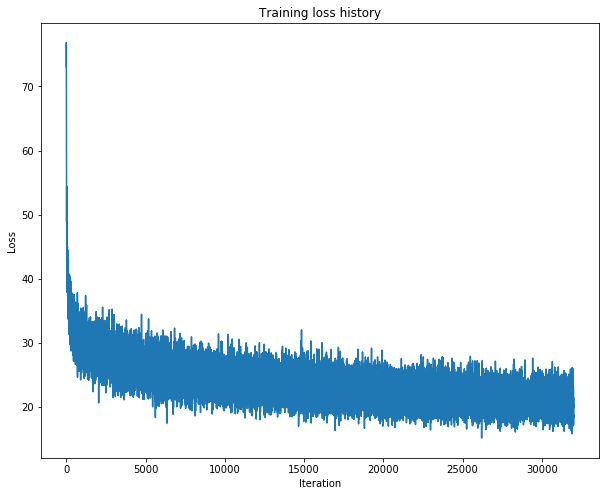

In [26]:
sdata = load_coco_data(max_train=40000)
#sdata = load_coco_data()

lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=1024,
          wordvec_dim=256,
          dtype=np.float32,
        )

lstm_solver = CaptioningSolver(lstm_model, sdata,
           update_rule='adam',
           num_epochs=20,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

lstm_solver.train()

# Plot the training losses
plt.plot(lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()


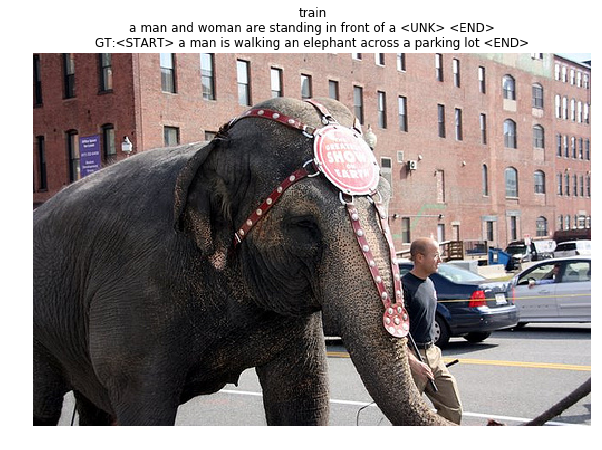

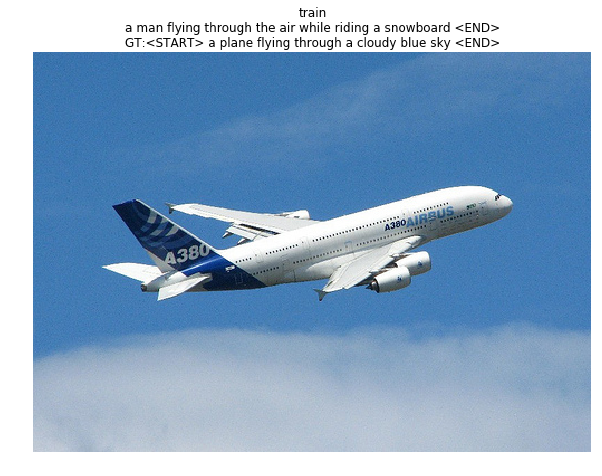

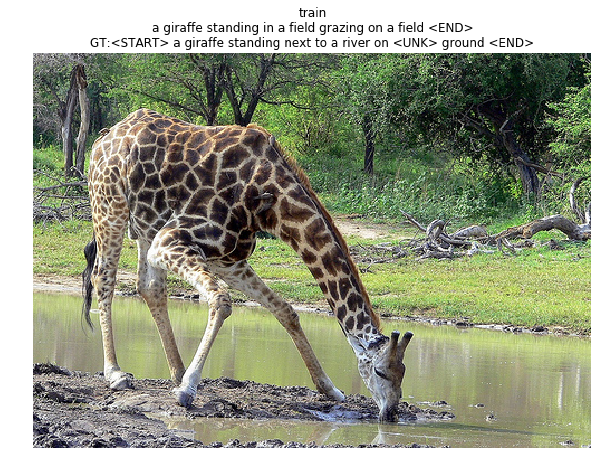

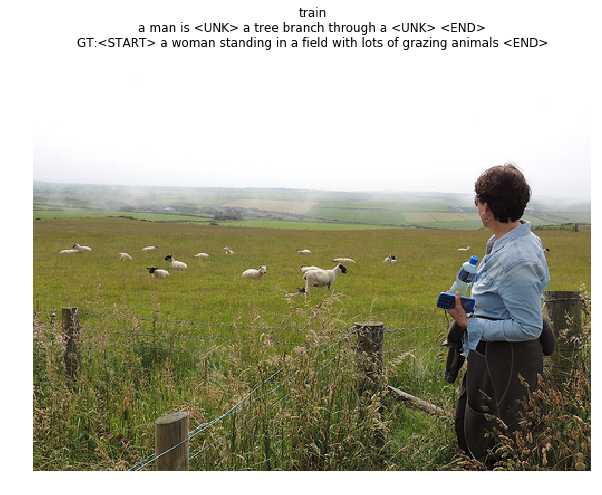

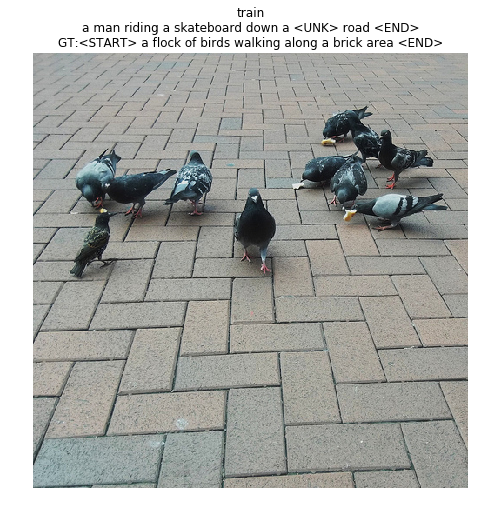

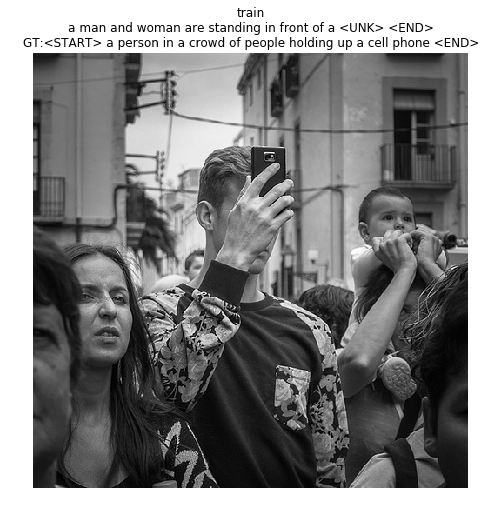

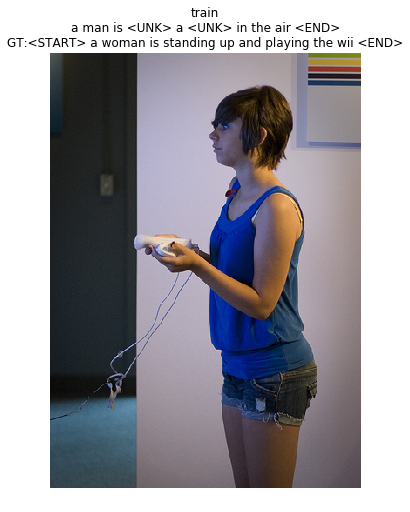

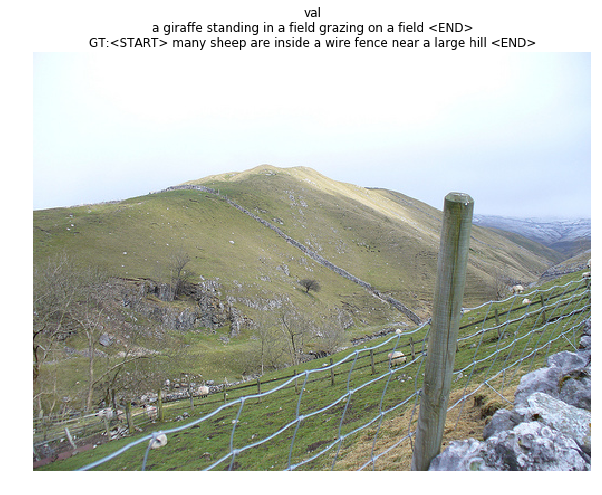

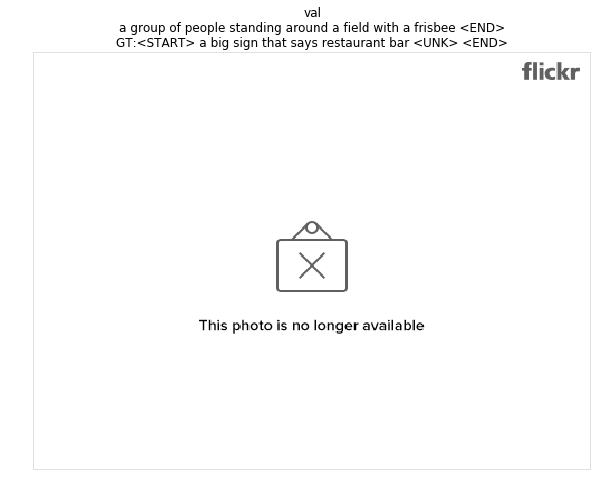

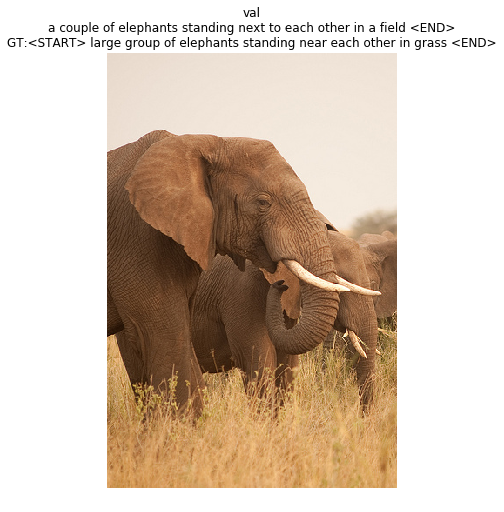

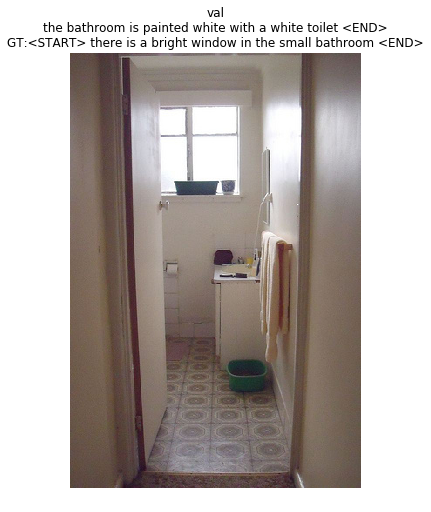

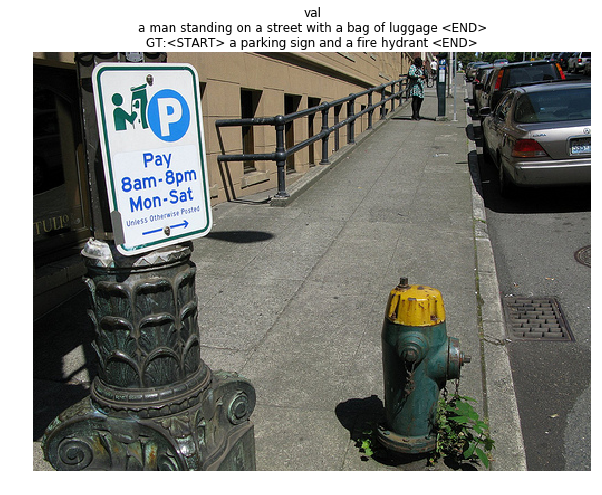

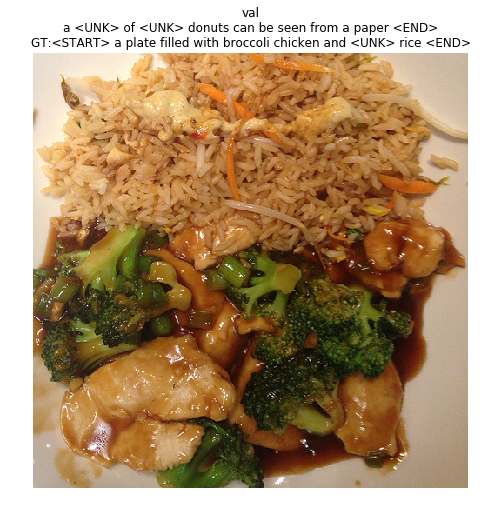

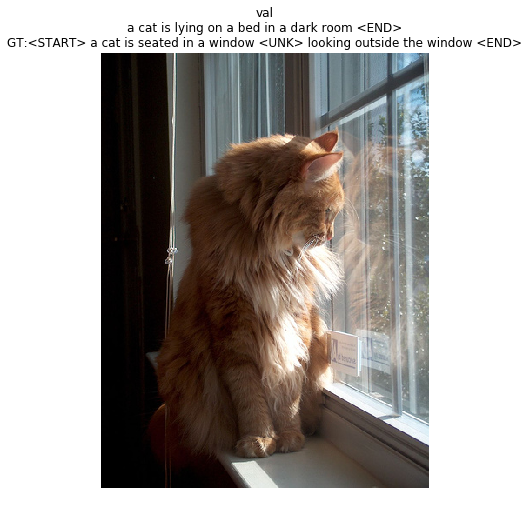

In [32]:
for split in ['train', 'val']:
  minibatch = sample_coco_minibatch(sdata, split=split, batch_size=7)
  gt_captions, features, urls = minibatch
  gt_captions = decode_captions(gt_captions, data['idx_to_word'])

  sample_captions = lstm_model.sample(features)
  sample_captions = decode_captions(sample_captions, data['idx_to_word'])

  for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
    plt.imshow(image_from_url(url))
    plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
    plt.axis('off')
    plt.show()